## 🏠 House Prices - XGBoost

### Destaques do Modelo XGBoost 

* **Pré-processamento inicial:** leitura dos dados e remoção de colunas com mais de 10% de valores ausentes, garantindo um conjunto de treino consistente e sem variáveis excessivamente incompletas.

* **Transformação das variáveis:** aplicação de imputação por mediana e padronização nas variáveis numéricas, enquanto as categóricas são convertidas via One-Hot Encoding. Todo o fluxo é integrado em um único ColumnTransformer para assegurar coerência durante treino e inferência.

* **Treinamento do modelo:** construção de um pipeline com o XGBRegressor. O modelo é treinado utilizando a variável alvo em escala logarítmica para maior estabilidade e desempenho preditivo.


## 1. Bibliotecas


In [1]:
# =====================================================
# 🏠 House Prices - XGBoost
# =====================================================
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, 
                       message='Found unknown categories in columns')
import time
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# Scikit-learn - Model selection e avaliação
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV

# Scikit-learn - Pré-processamento e pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# XGBoost
from xgboost import XGBRegressor

# Scikit-learn - Métricas de avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Distribuições para busca de hiperparâmetros
from scipy.stats import randint, uniform,loguniform

from setup_notebook import setup_path
setup_path()
from src.model_utils import *
from joblib import dump,load

## 2. Dataload & preprocessamento

In [2]:
# =====================================================
# 📁 1. Leitura dos dados
# =====================================================
dfo = pd.read_csv("/home/akel/PycharmProjects/Kaggle/HousePrices/data/train.csv")
df_train=dfo.copy()
# =====================================================
# ⚙️ 2. carregamento dos preprocessador 
# =====================================================
preprocessador0 = load("preprocessador_v0.joblib")

# =====================================================
# 🧹 3. Pré-processamento inicial
# =====================================================
# remoção de colunas com muitos nulos (> 10%)
colnull_train=df_train.columns[(df_train.isnull().sum()/df_train.shape[0]>0.1)] # 
df_train=df_train.drop(columns=colnull_train,axis=1)
id_train=df_train['Id']

# =====================================================
#  🤖 4.Modelos
# =====================================================
model_xg0    = XGBRegressor( objective='reg:squarederror',random_state=42,n_jobs=-1 ) 
XGB0         = pipe_models(model_xg0 , preprocessador0)

model_xg1    = XGBRegressor( objective='reg:squarederror', n_estimators=1000,
                         subsample= 0.8,max_depth= 6,learning_rate= 0.1,
                         colsample_bytree= 0.8,random_state=42,n_jobs=-1 ) 
XGB1         = pipe_models(model_xg1 , preprocessador0)

model_xg2    = XGBRegressor( objective='reg:squarederror', n_estimators=700,
                         subsample= 0.6,reg_lambda= 0.5,reg_alpha= 1.0,
                         max_depth= 3,learning_rate= 0.073,
                         colsample_bytree= 0.7,
                         n_jobs=-1 ) 
XGB2         = pipe_models(model_xg2 , preprocessador0)

## 2.Treinamento

In [7]:
X=df_train.drop(['Id', 'SalePrice'], axis=1)
y_log=np.log1p(df_train['SalePrice'])

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=42)
XGB0.fit(X_train, y_train)
y_pred = XGB0.predict(X_test)

res0=metricas_model(y_test, y_pred, 'XGBOOST-0')
r20=valida(X,y_log,model=XGB0,N=7)

🤖 XGBOOST-0
MAE:   0.0976
RMSE:  0.145
R²:    0.876
validação cruzada (K-Fold Cross Validation)
Fold 1: R² = 0.8889
Fold 2: R² = 0.9134
Fold 3: R² = 0.8931
Fold 4: R² = 0.7531
Fold 5: R² = 0.8919
Fold 6: R² = 0.8851
Fold 7: R² = 0.8969

📊 R² médio: 0.8746 ± 0.0503


In [4]:
XGB1.fit(X_train, y_train)
y_pred = XGB1.predict(X_test)

res1=metricas_model(y_test, y_pred, 'XGBOOST-1')

r21=valida(X,y_log,model=XGB1,N=7)

🤖 XGBOOST-1
MAE:   0.0894
RMSE:  0.132
R²:   0.8973
validação cruzada (K-Fold Cross Validation)
Fold 1: R² = 0.8952
Fold 2: R² = 0.9117
Fold 3: R² = 0.8997
Fold 4: R² = 0.7674
Fold 5: R² = 0.9027
Fold 6: R² = 0.9008
Fold 7: R² = 0.9162

📊 R² médio: 0.8848 ± 0.0484


In [5]:
XGB2.fit(X_train, y_train)
y_pred = XGB2.predict(X_test)

res2=metricas_model(y_test, y_pred, 'XGBOOST-2')

r22=valida(X,y_log,model=XGB2,N=7)

🤖 XGBOOST-2
MAE:   0.0838
RMSE:  0.124
R²:   0.9093
validação cruzada (K-Fold Cross Validation)
Fold 1: R² = 0.9088
Fold 2: R² = 0.9216
Fold 3: R² = 0.8990
Fold 4: R² = 0.8112
Fold 5: R² = 0.9090
Fold 6: R² = 0.9016
Fold 7: R² = 0.9175

📊 R² médio: 0.8955 ± 0.0352


,Modelo,MAE,RMSE,R²
0,XGBOOST-0,0.0976,0.145,0.8760
1,XGBOOST-1,0.0894,0.132,0.8973
2,XGBOOST-2,0.0838,0.124,0.9093


,Modelo,R2_Médio,R2_Std
0,XGB0,0.874625,0.050307
1,XGB1,0.884827,0.048389
2,XGB2,0.895510,0.035221


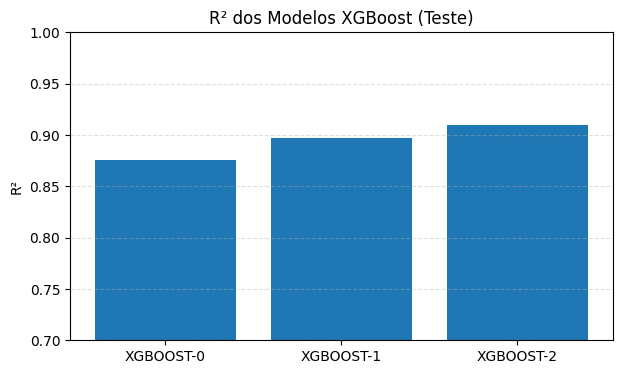

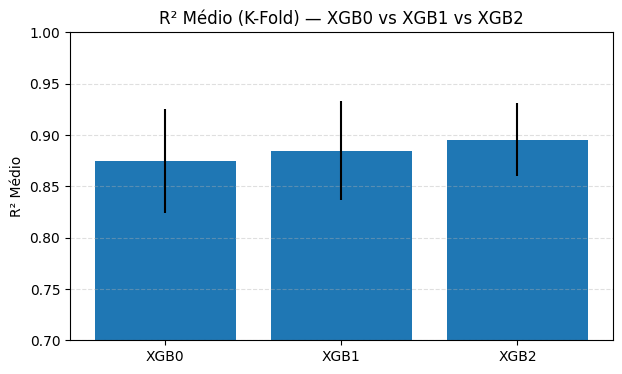

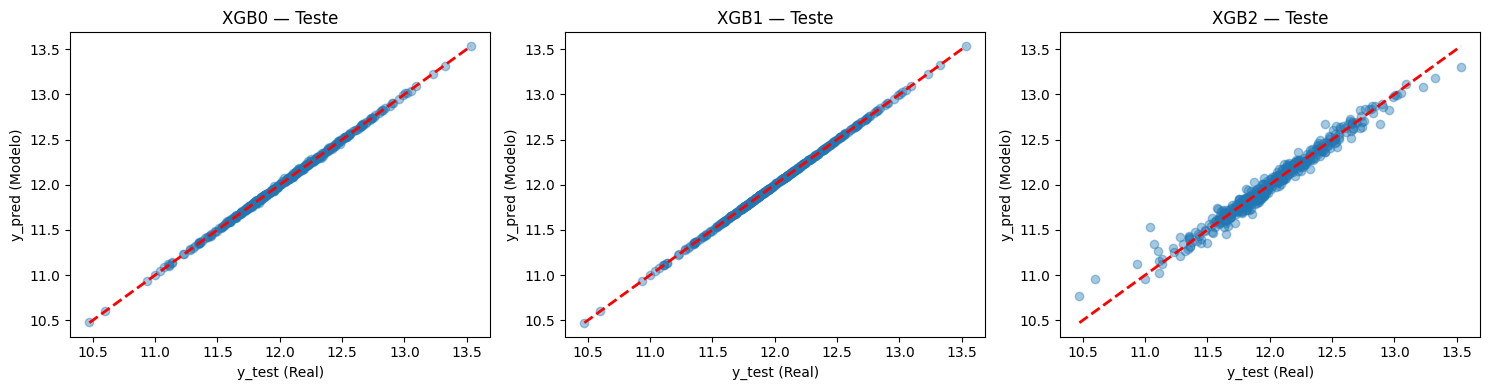

In [6]:
import matplotlib.pyplot as plt

# =====================================================
# 1. Organizar resultados em DataFrame
# =====================================================

resultados_teste = pd.DataFrame([
    res, res1, res2
])

resultados_cv = pd.DataFrame({
    "Modelo": ["XGB0", "XGB1", "XGB2"],
    "R2_Médio": [np.mean(r20), np.mean(r21), np.mean(r22)],
    "R2_Std":   [np.std(r20),  np.std(r21),  np.std(r22)]
})

display(resultados_teste)
display(resultados_cv)

# =====================================================
# 2. Gráfico — R² no conjunto de teste
# =====================================================

plt.figure(figsize=(7,4))
plt.bar(resultados_teste['Modelo'], resultados_teste['R²'])
plt.title("R² dos Modelos XGBoost (Teste)")
plt.ylabel("R²")
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

# =====================================================
# 3. Gráfico — R² médio da validação cruzada
# =====================================================

plt.figure(figsize=(7,4))
plt.bar(resultados_cv['Modelo'], resultados_cv['R2_Médio'], yerr=resultados_cv['R2_Std'])
plt.title("R² Médio (K-Fold) — XGB0 vs XGB1 vs XGB2")
plt.ylabel("R² Médio")
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

# =====================================================
# 4. Gráfico de Dispersão — y_test vs y_pred para cada modelo
# =====================================================

predicoes = {
    "XGB0": XGB0.predict(X_test),
    "XGB1": XGB1.predict(X_test),
    "XGB2": XGB2.predict(X_test)
}

plt.figure(figsize=(15,4))

for i, (nome, y_p) in enumerate(predicoes.items(), 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_test, y_p, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2)
    plt.title(f"{nome} — Teste")
    plt.xlabel("y_test (Real)")
    plt.ylabel("y_pred (Modelo)")

plt.tight_layout()
plt.show()